In [34]:
import cv2, imageio, nibabel, os, glob
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.transform import resize
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img

from config import config as cfg
import matplotlib.pyplot as plt
import skimage.io as io

# Visualizing ground truth

In [125]:
img_file = cfg['dataset_path'] + r'\HGG\BraTS19_2013_2_1\BraTS19_2013_2_1_flair.nii.gz'
nii_file = cfg['dataset_path'] + r'\HGG\BraTS19_2013_2_1\BraTS19_2013_2_1_seg.nii.gz'
slice = 115

## Method 1

In [163]:
mask_data = nibabel.load(nii_file)
img_data = nibabel.load(img_file)

mask_array = mask_data.get_fdata()
img_array = img_data.get_fdata()

img = img_array[:, :, slice]
mask = mask_array[:,:,slice]
#img = resize(img, (240, 240, 3), order=0, preserve_range=True, anti_aliasing=False)
mask.shape

(240, 240)

In [131]:
np.unique(mask)

array([0., 2.])

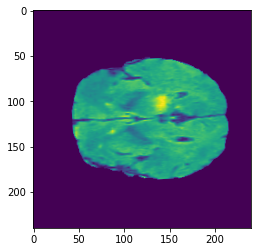

In [132]:
plt.imshow(img)

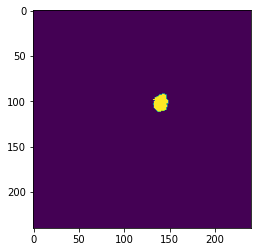

In [133]:
plt.imshow(mask)

## Method 2

In [162]:
img_2 = io.imread(nii_file, plugin='simpleitk')
gt = img_2[slice,:,:]
gt = np.flip(gt, axis=1)
gt = np.rot90(gt)
gt.shape

(240, 240)

In [160]:
np.unique(gt)

array([0, 2], dtype=int16)

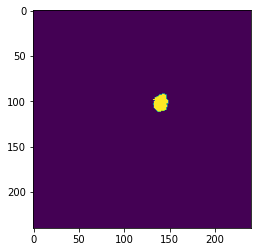

In [161]:
plt.imshow(gt)

In [164]:
paths = pd.read_csv('train_set.csv')
gt_path = cfg['images_path'] + paths['imgs'][1]

In [165]:
gt = cv2.imread(gt_path)
print(gt.shape)
print(gt.max())

(240, 240, 3)
255


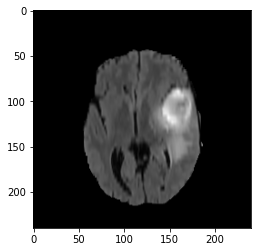

In [166]:
plt.imshow(gt)

## Generators

In [167]:
class BratsGenerator(tf.keras.utils.Sequence):
    def __init__(self, tuples, img_size=(128, 128), batch_size=1):
        self.input_img_paths = [tuples[i][0] for i in range(len(tuples))]
        self.target_img_paths = [tuples[i][1] for i in range(len(tuples))]

        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, index):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = index * self.batch_size

        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
                
        
        return x, y

In [169]:
from data_preparation.loaders import *
data = Dataset(cfg['dataset_path'], cfg['images_path'], cfg['modality'],
                initial_slice=cfg['initial_slice'], final_slice=cfg['final_slice'], extract=False)

>> Filtering black images (without ground truth)..
>> Searching for sets in csv format..


In [176]:
train_generator = BratsGenerator(data.train, batch_size=1)

In [177]:
gt_batch = train_generator[0][1].shape

In [180]:
gt = gt_batch[0]

In [182]:
gt.shape

AttributeError: 'int' object has no attribute 'shape'